In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from scipy.stats import cauchy
import powerlaw
import networkx as nx
import random
from Person import Person
from EnronEmail import EnronEmail
from DegreeDistribution import DegreeDistribution

In [61]:
# emails = pd.read_csv('active_emails/active_emails.csv')
emails = pd.read_csv('active_emails/active_emails.csv')

In [62]:
emails['recipients'] = emails['recipients'].apply(lambda x: x.split(' '))
emails

,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8
...,...,...,...,...,...,...,...
98236,system.administrator@enron.com,[elizabeth.sager@enron.com],2001-12-31 23:00:06+00:00,Your mailbox is over its size limit,<5967809.1075859126213.JavaMail.evans@thyme>,0,23
98237,system.administrator@enron.com,[kay.mann@enron.com],2001-12-31 23:00:11+00:00,Your mailbox is over its size limit,<24436699.1075855246109.JavaMail.evans@thyme>,0,23
98238,system.administrator@enron.com,[b..sanders@enron.com],2001-12-31 23:00:14+00:00,Your mailbox is over its size limit,<3308063.1075859457637.JavaMail.evans@thyme>,0,23
98239,system.administrator@enron.com,[d..steffes@enron.com],2001-12-31 23:00:34+00:00,Your mailbox is over its size limit,<30237259.1075855209614.JavaMail.evans@thyme>,0,23


In [63]:
num_replies = emails['subject'].str.startswith("RE:").sum()
num_forwards = emails['subject'].str.startswith(("Fw:", "Fwd:", "FW:")).sum()
num_starters = len(emails) - num_replies - num_forwards

print(num_replies, num_forwards, num_starters)

20565 14890 62786


In [64]:
probabilities = [num_replies, num_forwards]
probabilities = [prob / num_starters for prob in probabilities]
print(probabilities)

[0.32754117159876406, 0.23715477972796484]


In [65]:
emails['date'] = pd.to_datetime(emails['date'], utc=True, infer_datetime_format=True)
emails.head()

/var/folders/1w/ty9_z0y12r72xymhb930rg9h0000gn/T/ipykernel_69005/1074924353.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  emails['date'] = pd.to_datetime(emails['date'], utc=True, infer_datetime_format=True)


,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8


In [66]:
# extract day of week as integer
emails['day_of_week'] = emails['date'].dt.dayofweek
emails['hour_of_week'] = emails['date'].dt.hour + emails['day_of_week'] * 24
emails.head()

,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8


In [67]:
# show emails sorted by date
emails.sort_values('date', inplace=True)
emails.head()

,sender,recipients,date,subject,message_id,day_of_week,hour_of_week
0,chris.foster@enron.com,[kim.ward@enron.com],2001-01-01 01:38:00+00:00,2001 natural gas forecast,<29779853.1075851847407.JavaMail.evans@thyme>,0,1
1,sue.nord@enron.com,[margo.reyna@enron.com],2001-01-01 04:29:00+00:00,Re: CA Quarterly Fee Statement,<28595177.1075843766562.JavaMail.evans@thyme>,0,4
2,sue.nord@enron.com,"[barbara.hueter@enron.com, jeff.dasovich@enron...",2001-01-01 04:59:00+00:00,Re: Ohio Telecommunications Legislation,<17528586.1075843766536.JavaMail.evans@thyme>,0,4
3,sheila.tweed@enron.com,"[mark.haedicke@enron.com, elizabeth.sager@enro...",2001-01-01 05:11:00+00:00,Commission Hearings on Rate Stabilization Plan...,<20708722.1075853232986.JavaMail.evans@thyme>,0,5
4,john.arnold@enron.com,[john.lavorato@enron.com],2001-01-01 08:36:00+00:00,Re:,<27978344.1075857641184.JavaMail.evans@thyme>,0,8


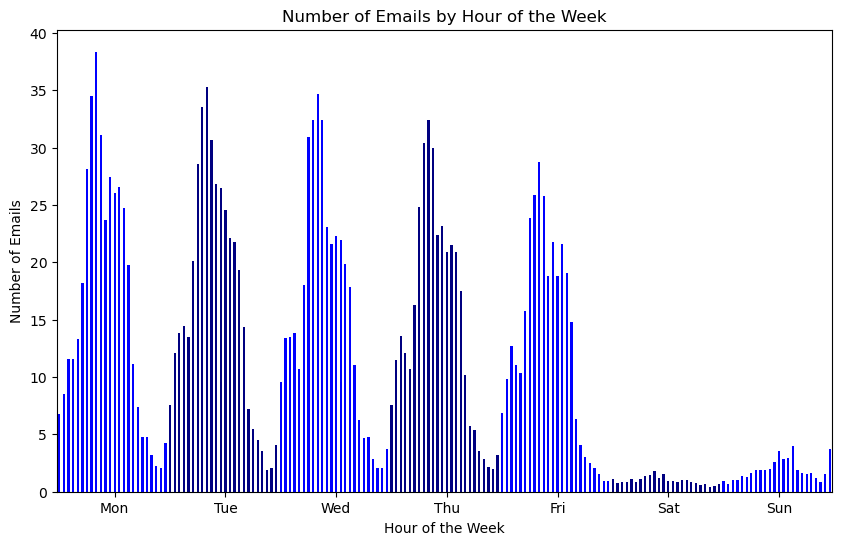

In [68]:
# Group the emails by hour of the week and calculate the size of each group
grouped_emails = emails.groupby('hour_of_week').size()

# Calculate the average number of emails per hour
average_emails = grouped_emails / (365 / 7)

colors = ['blue' if (hour // 24) % 2 == 0 else 'navy' for hour in range(168)]

# Plot the number of emails by hour of the week
average_emails.plot(kind='bar', color=colors, figsize=(10, 6))

# Set the x and y-axis labels
plt.xlabel('Hour of the Week')
plt.ylabel('Number of Emails')

plt.xticks(range(12, 24 * 7, 24), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Set the title of the plot
plt.title('Number of Emails by Hour of the Week')

# Show the plot
plt.show()

In [69]:
# calculate the average number of emails per hour
average_emails = grouped_emails / (365 / 7)
average_emails.head(), len(average_emails)

(hour_of_week
 0     6.808219
 1     8.476712
 2    11.564384
 3    11.564384
 4    13.271233
 dtype: float64,
 168)

In [70]:
all_people = dict()
all_emails = dict()

for index, row in emails.iterrows():
    email = EnronEmail(row['message_id'], row['sender'],
                       row['recipients'], row['date'])
    all_emails[email.id] = email
    if email.sender not in all_people:
        all_people[email.sender] = Person(email.sender)

    for recipient in email.recipients:
        if recipient not in all_people:
            all_people[recipient] = Person(recipient)
        all_people[recipient].received[email.id] = email
        all_people[email.sender].sent[email.id] = email
        all_people[email.sender].recipients.add(recipient)

In [73]:
graph = nx.Graph()
for person in all_people.values():
    for email in person.sent.values():
        for recipient in email.recipients:
            graph.add_edge(person.email, recipient)
            
print(len(graph.nodes), len(graph.edges))

5555 39316


In [74]:
# list of length of each node's edges
graph_degrees = [len(edges) for node, edges in graph.adjacency()]
# list of node emails in the order of the degrees
graph_emails = [node for node, edges in sorted(graph.adjacency(), key=lambda x: len(x[1]), reverse=True)]
graph_degrees_sent = [len(all_people[email].sent) for email in graph_emails]

In [114]:
data = {'Email': [], 'Sent': [], 'Connections': []}

# for person in all_people.values():
#     data['Email'].append(person.email)
#     data['Received'].append(len(person.received))
#     data['Sent'].append(len(person.sent))
#     data['Recipients'].append(len(person.recipients))
for email, connections, sent_degree in zip(graph_emails, graph_degrees, graph_degrees_sent):
    data['Email'].append(email)
    data['Sent'].append(sent_degree)
    data['Connections'].append(connections)

activity = pd.DataFrame(data)
activity

,Email,Sent,Connections
0,louise.kitchen@enron.com,769,46
1,john.lavorato@enron.com,324,46
2,tana.jones@enron.com,1346,67
3,jeff.dasovich@enron.com,2999,142
4,sally.beck@enron.com,697,40
...,...,...,...
5550,t.campbell@enron.com,1,1
5551,team.andrews@enron.com,1,1
5552,schlecht.schlecht@enron.com,1,10
5553,ron.spain@enron.com,1,1


In [115]:
# create dictionaries for the number of people who received/sent a certain number of emails
sent = dict()
connectivity = dict() # number different people someone is connected with

for degree in graph_degrees_sent:
    sent[degree] = sent.get(degree, 0) + 1

for email, edges in graph.adjacency():
    connectivity[len(edges)] = connectivity.get(len(edges), 0) + 1

In [116]:
sorted(sent.keys(), reverse=True)[:10]

[2999, 2912, 1903, 1901, 1467, 1346, 1330, 1162, 1072, 952]

In [117]:
fit_sent = powerlaw.Fit(graph_degrees_sent)
fit_connected = powerlaw.Fit(graph_degrees)

print(f'Sent fit: {fit_sent.alpha}')
print(f'Connected fit: {fit_connected.alpha}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Sent fit: 2.0807028929278344
Connected fit: 2.960425682638


Values less than or equal to 0 in data. Throwing out 0 or negative values


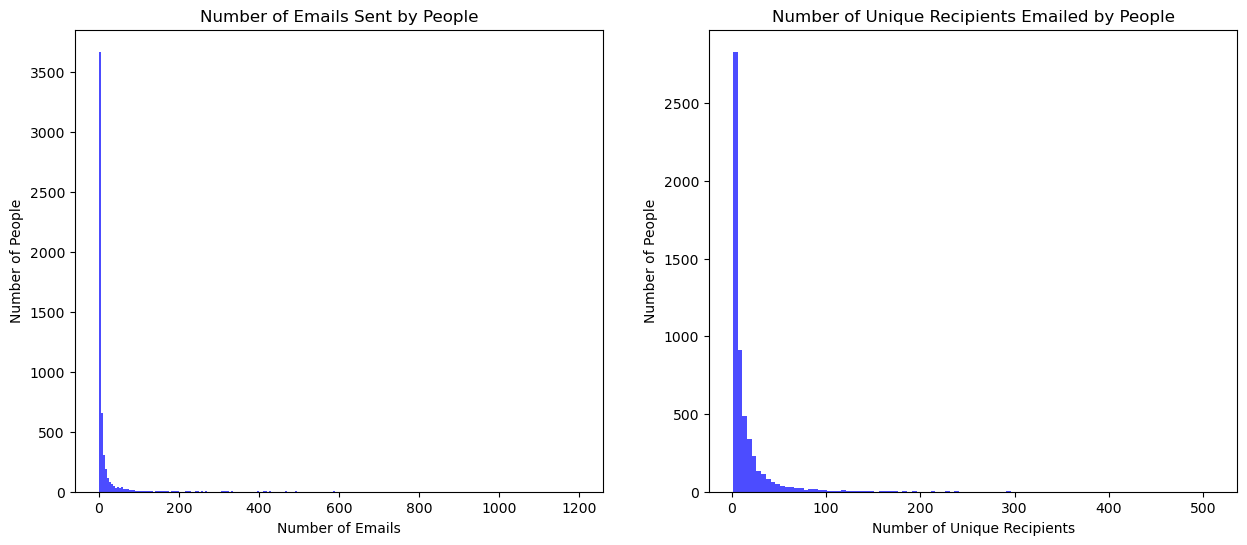

In [118]:
# Create a list for the number of emails received by each person
# num_activity = [len(person.sent) for person in all_people.values()]
# num_activity_rec = [len(person.recipients) for person in all_people.values()]
num_activity = graph_degrees_sent
num_activity_rec = graph_degrees
# Create a list of bin edges from the minimum to the maximum number of emails received, with a step size of 100
bin_size = 5
# bins_act = range(min(num_activity), max(num_activity) + bin_size, bin_size)
bins_act = range(min(num_activity), 1200 + bin_size, bin_size)
bins_act_rec = range(min(num_activity_rec), max(num_activity_rec) + bin_size, bin_size)

# create a side by side plot of the number of emails sent and received
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the histogram of the number of emails sent
ax1.hist(num_activity, bins=bins_act, color='blue', alpha=0.7, label='Sent')
ax1.set_xlabel('Number of Emails')
ax1.set_ylabel('Number of People')
ax1.set_title('Number of Emails Sent by People')

# Plot the histogram of the number of emails received
ax2.hist(num_activity_rec, bins=bins_act_rec, color='blue', alpha=0.7, label='Received')
ax2.set_xlabel('Number of Unique Recipients')
ax2.set_ylabel('Number of People')
ax2.set_title('Number of Unique Recipients Emailed by People')

plt.show()

In [122]:
def get_log_log(activity_dict: dict, fit_val: float=None):
    # P(x) = x^(-alpha)
    x = list(activity_dict.keys())
    y = list(activity_dict.values())
    y = [val / sum(y) for val in y]
    
    # Plot the log-log graph
    fig, ax1 = plt.subplots()
    ax1.loglog(x, y, marker='o', linestyle='')
    
    # add the fit line
    if fit_val:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        y_fit = [val ** -fit_val for val in x]
        ax2.loglog(x, y_fit, color='red', label=f'alpha = {fit_val}', linestyle=':')
        ax2.set_yticks([])  # hide the y-axis labels for the second axis
    
    ax1.set_xlabel('log(out_degree)')
    ax1.set_ylabel('log(number of people)')
    plt.title('Number of Emails Connections vs Number of People')
    return plt

/var/folders/1w/ty9_z0y12r72xymhb930rg9h0000gn/T/ipykernel_69005/1938642770.py:14: RuntimeWarning: divide by zero encountered in scalar power
  y_fit = [val ** -fit_val for val in x]


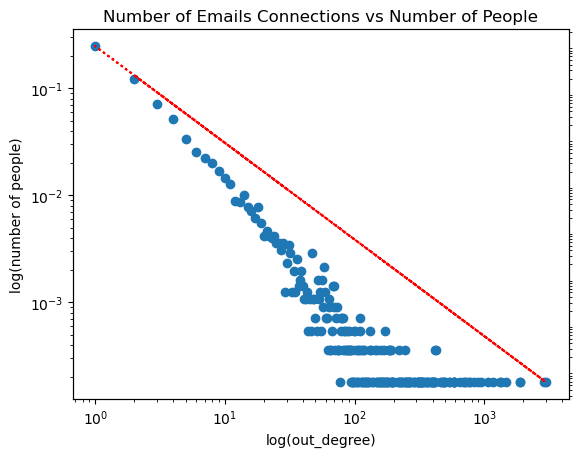

In [123]:
plt_sent = get_log_log(sent, fit_sent.alpha)
plt_sent.show()

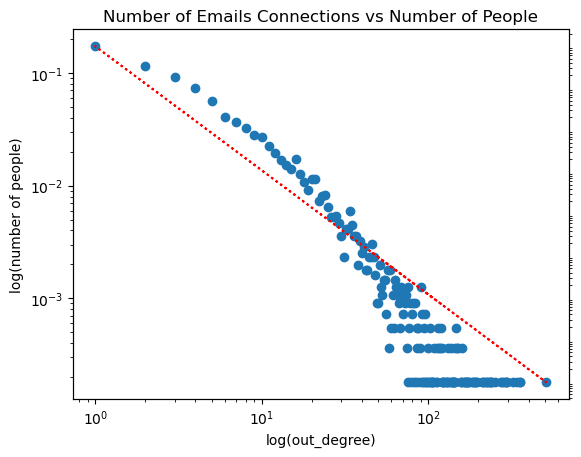

In [124]:
plt_recipients = get_log_log(connectivity, fit_connected.alpha)
plt_recipients.show()

In [125]:
# Define the empirical distribution of degrees (number of emails sent)
sent_dist = DegreeDistribution(sent)
connectivity_dist = DegreeDistribution(connectivity)

In [126]:
# the index is the degree and the value is the probability of that degree
sent_freq_dist = np.zeros(max(sent_dist.degrees) + 1)
for sent_degree, probability in zip(sent_dist.degrees, sent_dist.probabilities):
    sent_freq_dist[sent_degree] = probability

print(len(sent_freq_dist), max(sent_dist.degrees))

3000 2999


In [127]:
connectivity_freq_dist = np.zeros(max(connectivity_dist.degrees) + 1)
for recipients_degree, probability in zip(connectivity_dist.degrees, connectivity_dist.probabilities):
    connectivity_freq_dist[recipients_degree] = probability

print(len(connectivity_freq_dist), max(connectivity_dist.degrees))

510 509


In [128]:
def node_dp_degree_approximation(epsilon: float, theta: int, degree_dict: dict, deg_dist: np.ndarray):
    beta = epsilon / (np.sqrt(2) * (theta + 1))
    St_naive = 0  # smooth upper bound on local sensitivity of Naive Truncation
    for k in range(1, theta + 1):
        n = len([d for d in degree_dict.keys() if theta - k <= d <= theta + k])
        curr_s = (np.exp(-beta * k)) * (1 + k + n)
        St_naive = max(St_naive, curr_s)
        
    cauchy_scale = np.sqrt(2) * theta * St_naive / epsilon
    print('cauchy scale', cauchy_scale)
    cauchy_noise = cauchy.rvs(loc=0, scale=cauchy_scale, size=theta + 1)
    noisy_degs = deg_dist[:theta + 1] + cauchy_noise
    noisy_degs = np.maximum(noisy_degs, 0)
    noisy_degs = noisy_degs / sum(noisy_degs)
    
    return noisy_degs

In [129]:
approx_degrees = node_dp_degree_approximation(epsilon=0.1, theta=8, degree_dict=sent, deg_dist=sent_freq_dist)
approx_degrees

cauchy scale 2762.365969635189


array([0.02960119, 0.        , 0.        , 0.47324997, 0.04450297,
       0.41424439, 0.        , 0.        , 0.03840148])

In [130]:
# Generate N independent random draws from the distribution. If the sum is odd, add 1 to the smallest degree
def get_sorted_random_degree_sequence(deg_dist: DegreeDistribution, seq_size: int) -> np.ndarray:
    random_degrees = np.random.choice(
        deg_dist.degrees, size=seq_size, replace=True, p=deg_dist.probabilities)
    if sum(random_degrees) % 2 != 0:
        random_degrees[np.argmin(random_degrees)] += 1

    return np.sort(random_degrees)[::-1]


def get_capped_degree_seq(seq_size: int, deg_dist: DegreeDistribution) -> DegreeDistribution:
    degrees, probs = deg_dist.degrees, deg_dist.probabilities
    for i, degree in enumerate(degrees):
        if degree > seq_size:
            max_allowed_deg_idx = i - 1
            break
    else:
        max_allowed_deg_idx = len(degrees) - 1

    ds = degrees[:max_allowed_deg_idx]
    ps = probs[:max_allowed_deg_idx]
    # normalise the probabilities
    ps = [prob / sum(ps) for prob in ps]

    return DegreeDistribution(dict(zip(ds, ps)))

In [131]:
SEQ_SIZE = 2000
capped_sent_dist = get_capped_degree_seq(seq_size=SEQ_SIZE, deg_dist=sent_dist)
sorted_random_sents = get_sorted_random_degree_sequence(deg_dist=capped_sent_dist, seq_size=SEQ_SIZE)

capped_connectivity_dist = get_capped_degree_seq(seq_size=SEQ_SIZE, deg_dist=connectivity_dist)
sorted_random_connections = get_sorted_random_degree_sequence(deg_dist=capped_connectivity_dist, seq_size=SEQ_SIZE)

In [132]:
sorted_random_connections, len(sorted_random_connections)

(array([296, 242, 238, ...,   1,   1,   1]), 2000)

In [133]:
def get_candidate_nodes(sorted_degrees) -> list[int]: # residual_degs
    candidate_nodes = []
    for i, deg in enumerate(sorted_degrees):
        candidate_nodes += [i] * deg
    return candidate_nodes


def get_random_graph_from_degree(deg_seq: np.ndarray) -> np.ndarray:
    N = len(deg_seq)
    if sum(deg_seq) % 2 != 0:
        deg_seq[-1] += 1
    
    def fill_adj_matrix(res_degs, c, m, x):
        matrix = np.zeros((N, N))
        while res_degs:
            i = res_degs[0]
            valid_j = False
            while not valid_j:
                # pick a random index from the residual degrees (recipient of person i)
                idx = random.randint(1, len(res_degs) - 1)
                j = res_degs[idx]
                if i == j or matrix[i, j] > 0:
                    c += 1
                    if c >= m:
                        return None
                else:
                    valid_j = True
            matrix[i, j], matrix[j, i] = 1, 1
            if x > 0 and x % 100 == 0:
                print('here', x, i)
            res_degs.pop(idx)
            res_degs.pop(0)
                
        return matrix 
    
    residual_degs = get_candidate_nodes(deg_seq)
    adj_matrix = None
    x = 0
    while adj_matrix is None:
        adj_matrix = fill_adj_matrix(res_degs=residual_degs.copy(), c=0, m=2000, x=x)
        x += 1
    return adj_matrix

In [134]:
random_graph = get_random_graph_from_degree(sorted_random_connections)
random_graph

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## K means clustering

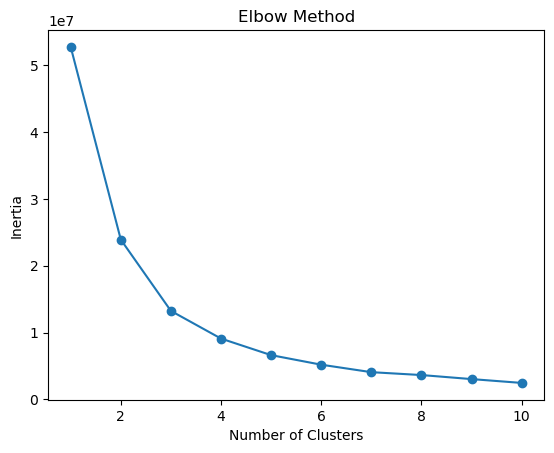

In [135]:
# Features for clustering
# X = activity[['Sent']]
X = activity[['Sent', 'Connections']]

inertia = []
for k in range(1, 11):
    # Create a KMeans object with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit the model to the data
    kmeans.fit(X)
    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [136]:
n_clusters = 4
X = activity[['Sent', 'Connections']]
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_means = kmeans.fit_predict(X)
activity['cluster'] = y_means
activity

,Email,Sent,Connections,cluster
0,louise.kitchen@enron.com,769,46,1
1,john.lavorato@enron.com,324,46,3
2,tana.jones@enron.com,1346,67,1
3,jeff.dasovich@enron.com,2999,142,2
4,sally.beck@enron.com,697,40,1
...,...,...,...,...
5550,t.campbell@enron.com,1,1,0
5551,team.andrews@enron.com,1,1,0
5552,schlecht.schlecht@enron.com,1,10,0
5553,ron.spain@enron.com,1,1,0


In [137]:
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X, y_means)
silhouette

0.8947234373832685

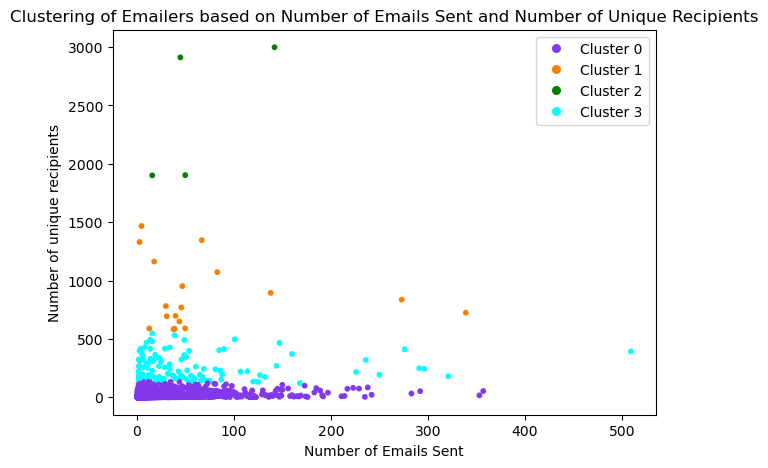

In [140]:
# Define the color map for the clusters
colour_map = {0: '#8338ec', 1: '#f77f00', 2: 'green', 3: 'cyan', 4: 'purple', 5: 'pink'}
plt.figure(figsize=(7, 5))

# Create the scatter plot with the specified colors
# plt.scatter(activity['Received'], activity['Sent'], c=activity['cluster'].map(color_map))
# plt.scatter(activity['Sent'], np.zeros(len(X)), c=activity['cluster'].map(colour_map), s=3)
plt.scatter(activity['Connections'], activity['Sent'],
            c=activity['cluster'].map(colour_map).tolist(), s=10)
plt.ylabel('Number of unique recipients')
plt.xlabel('Number of Emails Sent')
plt.title('Clustering of Emailers based on Number of Emails Sent and Number of Unique Recipients')

# Create the legend
plt.legend(handles=[Line2D([0], [0], marker='.', color='w', label=f'Cluster {cluster_num}', markerfacecolor=colour_map[cluster_num], markersize=15)
                    for cluster_num in range(n_clusters)])

plt.show()

In [142]:
# For each unique value in the 'Recipients' column, add to a dictionary a list of probabilities of the value in the 'Recipients' column being in each cluster
recipients_cluster_probs = dict()
for num_recipients in connectivity.keys():
    recipients_cluster_probs[num_recipients] = np.array([0] * n_clusters)
    
for index, row in activity.iterrows():
    num_recipients = row['Connections']
    cluster = row['cluster']
    recipients_cluster_probs[num_recipients][cluster] += 1
    
for num_recipients, cluster_probs in recipients_cluster_probs.items():
    recipients_cluster_probs[num_recipients] = cluster_probs / sum(cluster_probs)
        
recipients_cluster_probs

{46: array([0.76470588, 0.05882353, 0.        , 0.17647059]),
 67: array([0.8, 0.2, 0. , 0. ]),
 142: array([0., 0., 1., 0.]),
 40: array([0.85714286, 0.07142857, 0.        , 0.07142857]),
 3: array([0.99220273, 0.00194932, 0.        , 0.00584795]),
 17: array([0.98591549, 0.        , 0.        , 0.01408451]),
 50: array([0.6, 0.2, 0.2, 0. ]),
 28: array([0.96666667, 0.        , 0.        , 0.03333333]),
 5: array([0.99044586, 0.00318471, 0.        , 0.00636943]),
 138: array([0., 1., 0., 0.]),
 49: array([0.6, 0. , 0. , 0.4]),
 339: array([0., 1., 0., 0.]),
 125: array([0., 0., 0., 1.]),
 16: array([0.94736842, 0.        , 0.01052632, 0.04210526]),
 509: array([0., 0., 0., 1.]),
 13: array([0.9893617, 0.0106383, 0.       , 0.       ]),
 38: array([0.81818182, 0.09090909, 0.        , 0.09090909]),
 34: array([0.90909091, 0.        , 0.        , 0.09090909]),
 47: array([0.84615385, 0.07692308, 0.        , 0.07692308]),
 39: array([0.88888889, 0.05555556, 0.        , 0.05555556]),
 11: 

In [143]:
# create a DegreeDistribution object for the degree of total emails sent in each cluster
sent_cluster_dist = dict()
for cluster_num in range(n_clusters):
    sent_cluster_dist[cluster_num] = dict()
    
for index, row in activity.iterrows():
    cluster = row['cluster']
    sent = row['Sent']
    sent_cluster_dist[cluster][sent] = sent_cluster_dist[cluster].get(sent, 0) + 1
    
for cluster_num, sent_dist in sent_cluster_dist.items():
    sent_cluster_dist[cluster_num] = DegreeDistribution(sent_dist)
    
sent_cluster_dist

{0: DegreeDistribution(activity_dict={13: 48, 28: 20, 108: 1, 115: 1, 106: 2, 117: 1, 122: 1, 119: 2, 89: 2, 111: 4, 68: 8, 59: 7, 101: 3, 73: 5, 58: 12, 93: 2, 45: 6, 129: 1, 95: 2, 132: 3, 69: 5, 8: 112, 78: 3, 20: 23, 79: 4, 63: 5, 21: 26, 75: 2, 15: 43, 14: 56, 36: 14, 16: 40, 81: 4, 64: 6, 126: 1, 70: 8, 90: 3, 27: 17, 99: 3, 40: 8, 131: 1, 86: 2, 57: 5, 62: 2, 61: 4, 77: 1, 49: 6, 92: 2, 55: 3, 120: 1, 39: 11, 33: 7, 104: 1, 34: 11, 52: 9, 88: 2, 51: 3, 43: 7, 53: 6, 60: 4, 98: 1, 110: 3, 41: 6, 112: 2, 84: 3, 54: 7, 37: 8, 32: 16, 74: 2, 91: 2, 47: 16, 31: 19, 136: 1, 22: 23, 83: 3, 105: 1, 67: 3, 97: 1, 48: 6, 116: 2, 25: 20, 125: 1, 96: 1, 19: 31, 114: 1, 100: 1, 87: 3, 42: 6, 72: 4, 50: 4, 56: 9, 24: 23, 85: 2, 80: 4, 23: 22, 102: 2, 109: 2, 38: 9, 9: 93, 35: 7, 26: 20, 10: 80, 29: 7, 46: 3, 82: 2, 18: 43, 5: 187, 76: 2, 6: 142, 65: 2, 2: 675, 71: 2, 17: 34, 3: 398, 0: 934, 30: 13, 7: 125, 66: 2, 44: 3, 12: 49, 11: 71, 4: 285, 94: 1, 1: 1376}),
 1: DegreeDistribution(activity

In [144]:
emails_sent = np.array([0] * len(sorted_random_connections))
for i, num_recipients in enumerate(sorted_random_connections):
    sample_cluster = np.random.choice(range(n_clusters), p=recipients_cluster_probs[num_recipients])
    cluster_sent_dist = sent_cluster_dist[sample_cluster]
    # Number of sent emails must be at least the number of recipients
    filtered_sent_dist = cluster_sent_dist.get_dist_with_min_degree(min_degree=min(num_recipients, 1))
    num_sent = np.random.choice(filtered_sent_dist.degrees, p=filtered_sent_dist.probabilities)
    emails_sent[i] = num_sent
    
# normalise the number of emails sent distribution
emails_sent = emails_sent / sum(emails_sent)
print(emails_sent)

[5.00277932e-03 1.85288123e-04 2.64697319e-05 ... 5.29394637e-05
 3.70576246e-04 5.29394637e-05]


In [145]:
# Scale the number of emails to the number of people in the network
email_scale = SEQ_SIZE / len(all_people)
email_scale

0.36003600360036003

In [146]:
# average_emails *= email_scale
# average_emails /= email_scale

In [147]:
def get_email_count(activity_prop, max_rate, week_hour):
    max_emails = np.random.poisson(max_rate * activity_prop)
    
    actual_emails = 0
    for i in range(max_emails):
        uniform_sample = np.random.uniform(0, 1)
        if uniform_sample < average_emails[week_hour] / max_rate:
            actual_emails += 1
            
    return actual_emails

def get_recipients(node: int, graph: np.ndarray) -> set[int]:
    return set(np.where(graph[node] == 1)[0])

In [148]:
max_rate = np.max(average_emails)
# max_rate = np.max(average_emails) * 1000 / SEQ_SIZE

In [149]:
time_steps = 168 # 1 week

In [150]:
email_events = dict()

for node in range(SEQ_SIZE):
    for time_step in range(time_steps):
        week_hour = time_step % 168
        activity_prop = emails_sent[node]
        num_emails = get_email_count(activity_prop, max_rate, week_hour)
        if node not in email_events:
            email_events[node] = dict()
            
        email_events[node][time_step] = num_emails

In [151]:
sum(email_events[5].values())

0

In [152]:
np.mean(average_emails) * 168

1884.0739726027393

In [153]:
total_synthetic_emails = sum([sum(email_events[node].values()) for node in range(SEQ_SIZE)])

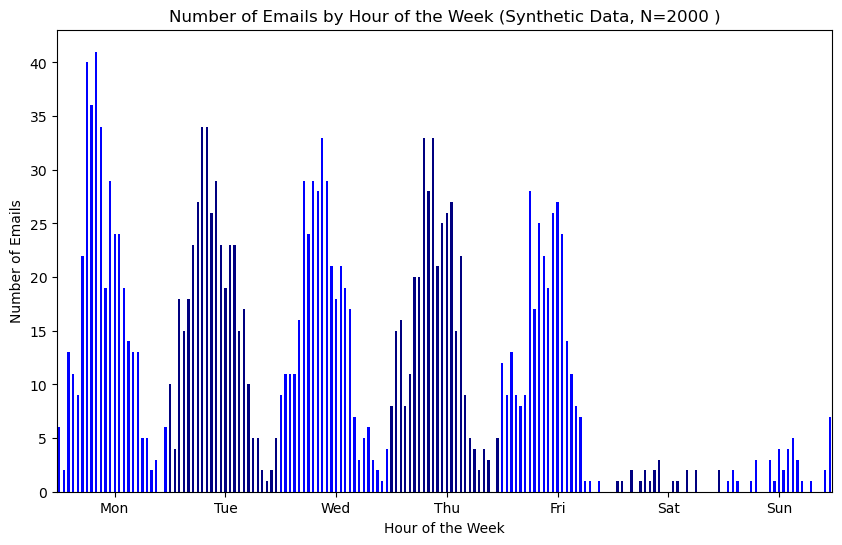

In [155]:
# plot the total number of emails for each hour of the week
total_emails = [0] * time_steps
hourly_dist = [0] * 24
for node in range(SEQ_SIZE):
    for time_step in range(168):
        total_emails[time_step] += email_events[node][time_step]
        hourly_dist[time_step % 24] += email_events[node][time_step]
        
# Plot the number of emails by hour of the week
pd.Series(total_emails).plot(kind='bar', color=colors, figsize=(10, 6))

# Set the x and y-axis labels
plt.xlabel('Hour of the Week')
plt.ylabel('Number of Emails')

plt.xticks(range(12, 24 * 7, 24), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Set the title of the plot
plt.title(f'Number of Emails by Hour of the Week (Synthetic Data, N={SEQ_SIZE} )')

# Show the plot
plt.show()

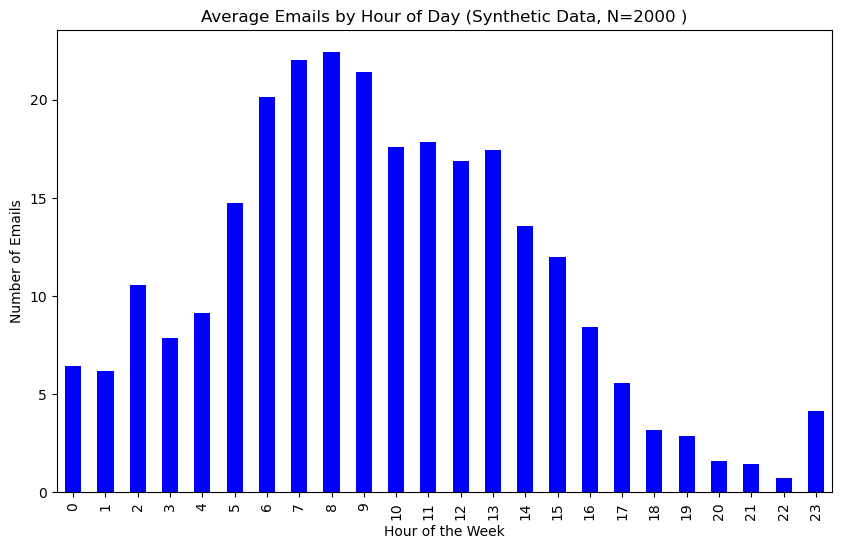

In [156]:
# Plot the number of emails by hour of the week

pd.Series([h / 7 for h in hourly_dist]).plot(kind='bar', color=colors, figsize=(10, 6))

# Set the x and y-axis labels
plt.xlabel('Hour of the Week')
plt.ylabel('Number of Emails')

# Set the title of the plot
plt.title(f'Average Emails by Hour of Day (Synthetic Data, N={SEQ_SIZE} )')

# Show the plot
plt.show()

In [157]:
# create networkx graph
synthetic_graph = nx.Graph()
for node in range(SEQ_SIZE):
    synthetic_graph.add_node(node)
    
for node in range(SEQ_SIZE):
    recipients = list(get_recipients(node, random_graph))
    for time_step in range(time_steps):
        num_emails = email_events[node][time_step]
        for _ in range(num_emails):
            if not recipients:
                continue
            # select a random number of recipients
            num_recipients = random.randint(1, len(recipients))
            selected_recipients = random.sample(recipients, num_recipients)
            for recipient in selected_recipients:
                synthetic_graph.add_edge(node, recipient)

In [158]:
# calculate preserved edge ratio
preserved_edges = len(synthetic_graph.edges) / len(graph.edges)
preserved_edges

In [160]:
len(synthetic_graph.edges)

5776

In [162]:
# calculate KS distance between the degree distributions of the original and synthetic graph
def get_degree_dist(graph: nx.Graph) -> DegreeDistribution:
    degrees = dict(graph.degree())
    degree_dist = DegreeDistribution(degrees)
    return degree_dist

In [ ]:
synthetic_degree_dist = get_degree_dist(synthetic_graph)

In [ ]:
ks_statistic = synthetic_degree_dist.ks_statistic(sent_dist)
ks_statistic

In [ ]:
# calculate power law fit for the synthetic graph
fit_synthetic = powerlaw.Fit(list(dict(synthetic_degree_dist.degrees).keys()))
fit_synthetic.alpha

In [ ]:
# calculate clustering coefficient for the synthetic graph
clustering_coefficient_synthetic = nx.average_clustering(synthetic_graph)
clustering_coefficient_synthetic

In [ ]:
original_coeff = nx.average_clustering(graph)
original_coeff